<a href="https://colab.research.google.com/github/bedirhansahin/pytorch-notes/blob/main/01_PyTorchWorkflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip uninstall torch -y
# !pip install torch==1.11.0

# PyTorch Workflow

- Let's explore an example PyTorch end-to-end workflow

In [2]:
what_were_covering = {
    1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluting a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}
what_were_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making predictions and evaluting a model (inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import numpy as np

## 1. Data (Preparing and Loading)

In [4]:
"""
Create known parameters

- weight
- bias
"""

weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

print(X[:5])
print("\n", y[:5])

tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800]])

 tensor([[0.3000],
        [0.3140],
        [0.3280],
        [0.3420],
        [0.3560]])


In [5]:
len(X), len(y)

(50, 50)

### Splitting Data into training and test sets

In [6]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

### Visualize the Data

In [7]:
"""
Plots training data, test data and compares predictions
"""
def plot_predictions(
    train_data=X_train,
    train_labels=y_train,
    test_data=X_test,
    test_labels=y_test,
    size=(5, 3.5),
    predictions=None
):
  plt.figure(figsize=size)
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training Data")  # Plot training data in blue
  plt.scatter(test_data, test_labels, c="g", s=4, label="Test Data")  # Plot test data in green

  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")  # If predictions is not None then plot it in red

  plt.legend(prop={"size": 14})

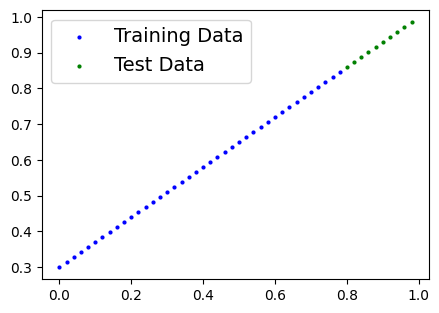

In [8]:
plot_predictions()

## 2. Build Model
- First PyTorch Model

In [9]:
"""
Create a linear regression model class
"""

class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()

    # Initialize model parameters
    self.weights = nn.Parameter(
        torch.randn(
            1,
            requires_grad=True,
            dtype=torch.float
            )
        )
    self.bias = nn.Parameter(
        torch.randn(
            1,
            requires_grad=True,
            dtype=torch.float
        )
    )
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias  # this is the linear regression formula

### PyTorch building essentials

* torch.nn - contains all of the buildings for computational graphs
* torch.nn.Parameter - what parameters should our model try and learn
* torch.nn.Module - The base class for all neuroal network modules, if you subclass it, you should overwrite forward()
* torch.optim - This where the optimizers in PyTorch live, they will help with gradient descent
* def forward() - All nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation

### Checking the contents of our PyTorch model

In [10]:
"""
Create a random seed
"""
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)

model_0 = LinearRegressionModel()
# model_0.parameters()
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [11]:
"""
List named parameters
"""

model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`

`torch.inference_mode()` removes unuseful things
We can use `torch.no_grad()` but `torch.inference_mode()` is preferred.

In [12]:
"""
Make prediction with model
"""

with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

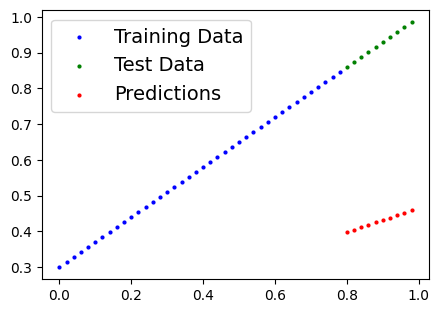

In [13]:
plot_predictions(predictions=y_preds)

## 3. Train model

Main idea of training is for a model to move unknown parameters to some known parameters.

* **Note:** Loss function may also be called cost function

Things we need to train:
* **Loss Function:** A function to measure how wrong your model's predictions are the ideal outputs, **lower is better**.

* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameter (e.g. weight & bias) to improve the loss function.

We Need:
* A training loop
* A testing loop

In [14]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [15]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [16]:
"""
Setup a loss function
"""
loss_fn = nn.L1Loss()

"""
Setup an optimizer
"""
optimizer = torch.optim.SGD(
  params=model_0.parameters(),
  lr=0.01  # learning rate => one of the most important hyperparameter
  )

### Building a training loop in PyTorch

0. Loop through the data
1. Forward pass (this involves data moving through our model's `forward()`) - also called forward propagation.
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss. (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss.


In [17]:
with torch.no_grad():
  list(model_0.parameters())

In [18]:
torch.manual_seed(RANDOM_SEED)
"""
An epoch is one loop through the data...
"""
epochs = 201

# Track different values
epoch_count, loss_values, test_loss_values = [], [], []

### Training
# 0.
for epoch in range(epochs):
  model_0.train()  # Train step

  # 1.
  y_pred = model_0(X_train)

  # 2.
  loss = loss_fn(y_pred, y_train)
  print(f"Loss: {loss}")

  # 3.
  optimizer.zero_grad()

  # 4.
  loss.backward()

  # 5.
  optimizer.step()

  ### Testing
  model_0.eval()  # Evaulation step

  with torch.inference_mode():  # turns off gradient tracking & a couple more things behind the scenes
    # 1.
    test_pred = model_0(X_test)

    # 2.
    test_loss = loss_fn(test_pred, y_test)

  # Print out What is happening
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss}")

    # Print out
    print(model_0.state_dict())

Loss: 0.31288138031959534
Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Loss: 0.3013603389263153
Loss: 0.28983935713768005
Loss: 0.2783183455467224
Loss: 0.26679736375808716
Loss: 0.2552763521671295
Loss: 0.24375534057617188
Loss: 0.23223432898521423
Loss: 0.22071333229541779
Loss: 0.20919232070446014
Loss: 0.1976713240146637
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Loss: 0.18615034222602844
Loss: 0.1746293306350708
Loss: 0.16310831904411316
Loss: 0.1515873372554779
Loss: 0.14006635546684265
Loss: 0.1285453587770462
Loss: 0.11702437698841095
Loss: 0.1060912236571312
Loss: 0.09681284427642822
Loss: 0.08908725529909134
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3

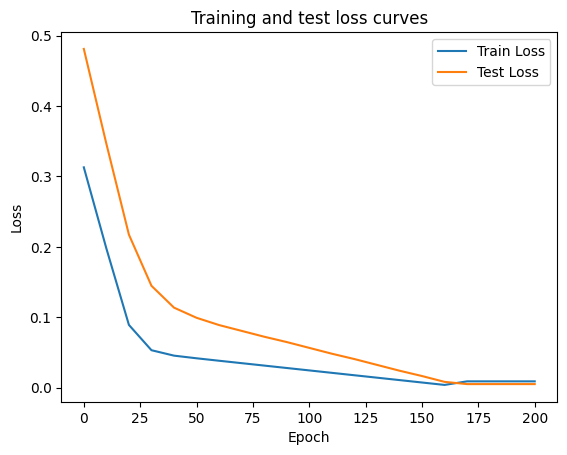

In [19]:
# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train Loss")
plt.plot(epoch_count, test_loss_values, label="Test Loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()


In [20]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

In [21]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6951])), ('bias', tensor([0.2993]))])

In [22]:
weight, bias

(0.7, 0.3)

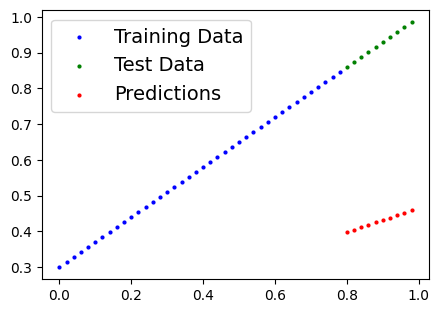

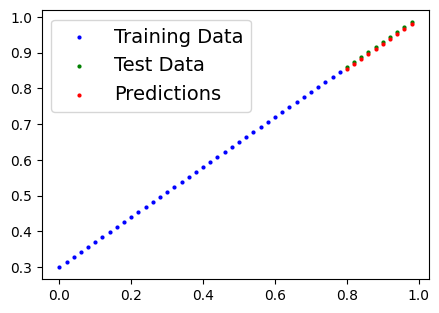

In [23]:
plot_predictions(predictions=y_preds)
plot_predictions(predictions=y_preds_new)

### Saving a model in PyTorch

There are three main methods you should know:
1. `torch.save()` - Save as Python's pickle format
2. `torch.load()` - Save as PyTorch Object
3. `torch.nn.Module.load_state_dict()` - Save state dictionary

In [24]:
"""
Saving the PyTorch Module
"""
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("drive/MyDrive/Colab Notebooks/models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_model_0.pth" # pth => PyTorch object
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dictionary
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(
    obj=model_0.state_dict(),
    f=MODEL_SAVE_PATH
    )

Saving model to: drive/MyDrive/Colab Notebooks/models/01_model_0.pth


In [25]:
!ls -l drive/MyDrive/'Colab Notebooks'/models

total 2
-rw------- 1 root root 1514 Nov  5 21:05 01_model_0.pth


### Loading a PyTorch model

In [26]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6951])), ('bias', tensor([0.2993]))])

In [27]:
"""
To load in a saved state_dict we have to instantiate a new instance of our model class
"""
loaded_model_0 = LinearRegressionModel()

In [28]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [29]:
"""
Load the saved state_dict of model_0
"""
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [30]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6951])), ('bias', tensor([0.2993]))])

In [31]:
"""
Make some predictions
"""
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8554],
        [0.8693],
        [0.8832],
        [0.8971],
        [0.9110],
        [0.9249],
        [0.9388],
        [0.9527],
        [0.9666],
        [0.9805]])

In [32]:
model_0.eval()
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.8554],
        [0.8693],
        [0.8832],
        [0.8971],
        [0.9110],
        [0.9249],
        [0.9388],
        [0.9527],
        [0.9666],
        [0.9805]])

In [33]:
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## Putting it all together

In [34]:
torch.__version__

'2.1.0+cu118'

Create device-agnostic code.

This means if we have got access to GPU, our code will use it. If no GPU available, the code use CPU.

In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using Device: {device}")

Using Device: cuda


In [36]:
!nvidia-smi

Sun Nov  5 21:05:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 1. Data

In [37]:
"""
Crate some data using linear regression formula of y = weight * X + bias
"""
weight = 0.7
bias = 0.3

"""
Create range values
"""
start = 0
end = 1
step = 0.02

"""
Create X and y (features and labels)
"""
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, errors will pop up
y = weight * X + bias

X[:10], y[:10]


(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [38]:
"""
Split Data
"""
train_split = int(0.8 * len(X))
X_train, y_train, X_test, y_test = X[:train_split], y[:train_split], X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)


(40, 40, 10, 10)

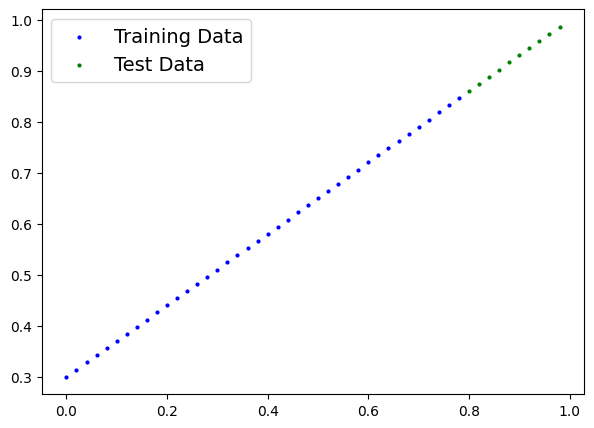

In [39]:
"""
Plot the Data
"""
plot_predictions(X_train, y_train, X_test, y_test, size=(7, 5))

### 2. Building a PyTorch Linear Model

In [40]:
"""
Create a linear model by subclassing nn.Module
"""
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    """
    Use nn.Linear() for creating the model parameters | also called: linear transform, dense layer, probing layer
    """
    self.linear_layer = nn.Linear(
        in_features=1,
        out_features=1
        )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

"""
Set the manual seed
"""
MANUAL_SEED = 42
torch.manual_seed(MANUAL_SEED)

model_1 = LinearRegressionModelV2()

print(model_1)
print(model_1.state_dict())

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
OrderedDict([('linear_layer.weight', tensor([[0.7645]])), ('linear_layer.bias', tensor([0.8300]))])


In [41]:
# Check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [42]:
# Set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### 3. Training

For training we need:
- Loss Function
- Optimizer
- Training Loop
- Testing Loop

In [43]:
"""
Setup loss function
"""
loss_fn = nn.L1Loss()  # Same as MAE (Mean Absolute Error)

"""
Setup optimizer
"""
optimizer = torch.optim.SGD(
    params=model_1.parameters(),
    lr=0.01
    )

In [44]:
### Training

torch.manual_seed(MANUAL_SEED)

epochs = 201

"""
Put data on the target device
"""
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  """
  1. Forward Pass
  """
  y_pred = model_1(X_train)

  """
  2. Calculate the Loss
  """
  loss = loss_fn(y_pred, y_train)

  """
  3. Optimizer zero grad
  """
  optimizer.zero_grad()

  """
  4. Perform Backpropagation
  """
  loss.backward()

  """
  5. Optimizer Step
  """
  optimizer.step()

  ### Testing
  model_1.eval()

  with torch.inference_mode():
    test_pred = model_1(X_test)
    test_loss = loss_fn(test_pred, y_test)

  ### Print Out What is Happening??

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")

Epoch: 0 | Loss: 0.5551779866218567 | Test Loss: 0.5739762187004089
Epoch: 10 | Loss: 0.439968079328537 | Test Loss: 0.4392664134502411
Epoch: 20 | Loss: 0.3247582018375397 | Test Loss: 0.30455657839775085
Epoch: 30 | Loss: 0.20954833924770355 | Test Loss: 0.16984669864177704
Epoch: 40 | Loss: 0.09433845430612564 | Test Loss: 0.03513690456748009
Epoch: 50 | Loss: 0.023886388167738914 | Test Loss: 0.04784907028079033
Epoch: 60 | Loss: 0.019956795498728752 | Test Loss: 0.045803118497133255
Epoch: 70 | Loss: 0.016517987474799156 | Test Loss: 0.037530567497015
Epoch: 80 | Loss: 0.013089174404740334 | Test Loss: 0.02994490973651409
Epoch: 90 | Loss: 0.009653178043663502 | Test Loss: 0.02167237363755703
Epoch: 100 | Loss: 0.006215683650225401 | Test Loss: 0.014086711220443249
Epoch: 110 | Loss: 0.00278724217787385 | Test Loss: 0.005814164876937866
Epoch: 120 | Loss: 0.0012645035749301314 | Test Loss: 0.013801801018416882
Epoch: 130 | Loss: 0.0012645035749301314 | Test Loss: 0.013801801018416

In [45]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6929]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.2925], device='cuda:0'))])

In [46]:
weight, bias

(0.7, 0.3)

### 4. Making and evaluating predictions

In [47]:
"""
Turn model into evaluation mode
"""
model_1.eval()

"""
Make predictions on the test data
"""
with torch.inference_mode():
  y_preds = model_1(X_test)

y_preds

tensor([[0.8468],
        [0.8607],
        [0.8746],
        [0.8884],
        [0.9023],
        [0.9161],
        [0.9300],
        [0.9438],
        [0.9577],
        [0.9716]], device='cuda:0')

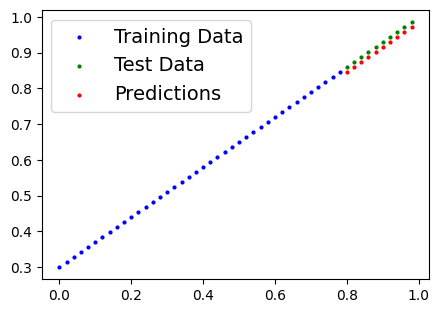

In [49]:
"""
Check out our model predictions visually
"""
plot_predictions(predictions=y_preds.cpu())

### 5. Saving and Loading

In [50]:
"""
Saving a PyTorch Model
"""
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("drive/MyDrive/Colab Notebooks/models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dictionary
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(
    obj=model_1.state_dict(),
    f=MODEL_SAVE_PATH
    )

Saving model to: drive/MyDrive/Colab Notebooks/models/01_model_1.pth


In [51]:
"""
Loading a PyTorch Model
"""
loaded_model_1 = LinearRegressionModelV2()

"""
Load the saved state_dict of model_1
"""
loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

"""
Put the loaded model to device
"""
loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [52]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [53]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6929]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.2925], device='cuda:0'))])

In [55]:
"""
Evaulate loaded model
"""
loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)

y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')